<a href="https://colab.research.google.com/github/reshalfahsi/quantum-transfer-learning-metastases-detection/blob/master/Quantum_Transfer_Learning_for_Lymph_Node_Metastases_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Transfer Learning for Lymph Node Metastases Detection**

## **Important Libraries**

### **Install**

In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics pennylane sh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 156.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 169.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 157.5 MB/s eta 0:00:00


### **Import**

In [ ]:
import os
import cv2
import sys
import copy
import math
import random
import hashlib
import warnings

import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from PIL import Image
from sh import gunzip

from torchvision.models import googlenet
from torchvision.datasets import PCAM
from torchvision.transforms import v2 as T

import pennylane as qml
from pennylane import numpy as np

try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint

from torchmetrics.classification import Accuracy

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [ ]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 619806494


In [ ]:
METRIC_TO_MONITOR = "val_acc"
METRIC_MODE       = "max"

In [ ]:
NUM_QUBIT = 4
NUM_EMBEDDING_LAYER = 2
NUM_CIRCUIT_LAYER = 6
MAX_EPOCH = 16
BATCH_SIZE = 256
LEARNING_RATE = 4e-3
BASE_LR_SCALE = 3e-4

In [ ]:
QUANTUM_DEVICE = "default.qubit"

## **Dataset**

In [ ]:
DATASET_TRANSFORM = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,)),
    ]
)

In [ ]:
"""
This part is important in order to avoid RAM overflow.
"""

USER_AGENT = "pytorch/vision"


def _decompress(
    from_path,
    remove_finished: bool = False,
):
    gunzip(from_path)
    if remove_finished:
        os.remove(from_path)


def calculate_md5(fpath, chunk_size: int = 1024 * 1024) -> str:
    if sys.version_info >= (3, 9):
        md5 = hashlib.md5(usedforsecurity=False)
    else:
        md5 = hashlib.md5()
    with open(fpath, "rb") as f:
        while chunk := f.read(chunk_size):
            md5.update(chunk)
    return md5.hexdigest()

def check_md5(fpath, md5: str, **kwargs) -> bool:
    return md5 == calculate_md5(fpath, **kwargs)


def check_integrity(fpath, md5 = None) -> bool:
    if not os.path.isfile(fpath):
        return False
    if md5 is None:
        return True
    return check_md5(fpath, md5)


def download_file_from_google_drive(
    file_id: str,
    root,
    filename = None,
    md5 = None,
):
    try:
        import gdown
    except ModuleNotFoundError:
        raise RuntimeError(
            "To download files from GDrive, 'gdown' is required."
            " You can install it with 'pip install gdown'."
        )

    root = os.path.expanduser(root)
    if not filename:
        filename = file_id
    fpath = os.fspath(os.path.join(root, filename))

    os.makedirs(root, exist_ok=True)

    if check_integrity(fpath, md5):
        return

    gdown.download(id=file_id, output=fpath, quiet=False, user_agent=USER_AGENT)

    if not check_integrity(fpath, md5):
        raise RuntimeError("File not found or corrupted.")


def _download(self) -> None:
    if self._check_exists():
        return

    for file_name, file_id, md5 in self._FILES[self._split].values():
        archive_name = file_name + ".gz"
        download_file_from_google_drive(
            file_id, str(self._base_folder), filename=archive_name, md5=md5
        )
        _decompress(str(self._base_folder / archive_name))


PCAM._download = _download

In [ ]:
class PCAMDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "experiment/dataset",
        batch_size: int = BATCH_SIZE,
        transform = DATASET_TRANSFORM,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transform

    def prepare_data(self):
        PCAM(self.data_dir, split="train", download=True)
        PCAM(self.data_dir, split="val", download=True)
        PCAM(self.data_dir, split="test", download=True)

    def setup(self, stage: str):
        if stage == "test":
            self.test_set = PCAM(
                self.data_dir,
                transform=self.transform,
                split="test",
            )

        if stage == "fit":
            self.train_set = PCAM(
                self.data_dir,
                transform=self.transform,
                split="train",
            )
            self.val_set = PCAM(
                self.data_dir,
                transform=self.transform,
                split="val",
            )

    def train_dataloader(self):
        return data.DataLoader(
            self.train_set,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return data.DataLoader(self.val_set,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return data.DataLoader(self.test_set,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            persistent_workers=True,
        )

In [ ]:
DATASET = PCAMDataModule

## **Model**

### **Utils**

In [ ]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Module**

In [ ]:
dev = qml.device(
    QUANTUM_DEVICE,
    wires=NUM_QUBIT,
)

@qml.qnode(dev)
def qnode(
    inputs,
    weights,
    emb_weights,
):
    qml.QAOAEmbedding(inputs, emb_weights, wires=range(NUM_QUBIT))
    qml.ParticleConservingU2(weights, wires=range(NUM_QUBIT))
    return [qml.expval(qml.PauliZ(wires=wire)) for wire in range(NUM_QUBIT)]

In [ ]:
class QuantumGoogLeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = googlenet(weights="DEFAULT")
        del self.model.aux1, self.model.aux2

        KERNEL_SIZE = self.model.fc.in_features // NUM_QUBIT
        del self.model.avgpool, self.model.dropout, self.model.fc

        self.transition = nn.Conv3d(
            1, 1, kernel_size=(KERNEL_SIZE, 3, 3), stride=(KERNEL_SIZE, 1, 1)
        )

        self.qfc = qml.qnn.TorchLayer(
            qnode,
            {
                "weights": (NUM_CIRCUIT_LAYER, 2 * NUM_QUBIT - 1),
                "emb_weights" : (NUM_EMBEDDING_LAYER, 2 * NUM_QUBIT),
            },
        )

        self.fc = nn.Linear(NUM_QUBIT, 1)

    def forward(self, x):

        x = self.model.conv1(x)
        x = self.model.maxpool1(x)
        x = self.model.conv2(x)
        x = self.model.conv3(x)
        x = self.model.maxpool2(x)

        x = self.model.inception3a(x)
        x = self.model.inception3b(x)
        x = self.model.maxpool3(x)
        x = self.model.inception4a(x)

        x = self.model.inception4b(x)
        x = self.model.inception4c(x)
        x = self.model.inception4d(x)

        x = self.model.inception4e(x)
        x = self.model.maxpool4(x)
        x = self.model.inception5a(x)
        x = self.model.inception5b(x)

        N, C, H, W = x.shape
        K = self.transition.kernel_size[0]

        x = F.relu(self.transition(x.view(-1, 1, C, H, W)).view(-1, C // K))
        x = F.relu(self.qfc(x))
        x = self.fc(x)

        return x

### **Wrapper**

In [ ]:
class QuantumTransferLearning(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.lr = LEARNING_RATE
        self.max_epoch = MAX_EPOCH
        self.lr_now = self.lr * 1e3

        self.arch = QuantumGoogLeNet()

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):

        x, y = batch
        y_hat = self(x).view(y.shape[0])
        y = y.view(y.shape[0])

        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        self.train_accuracy.update(y_hat.sigmoid(), y)

        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

        sch = self.lr_schedulers()
        sch.step()

    def on_train_epoch_end(self):
        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x).view(y.shape[0])
        y = y.view(y.shape[0]).long()
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.sigmoid(), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                report_str = f"[{MODEL_NAME}] Learning Rate Changed:"
                report_str += f" {lr_now_} - Epoch: {self.current_epoch}"
                print(report_str)
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x).view(y.shape[0])
        y = y.view(y.shape[0]).long()
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        self.test_accuracy.update(y_hat.sigmoid(), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Accuracy
        acc_img_file = f"experiment/training/{MODEL_NAME}_acc_plot.png"
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

    def configure_optimizers(self):
        optimizer = optim.SGD(self.arch.parameters(), lr=self.lr)
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.CyclicLR(
                optimizer,
                base_lr=BASE_LR_SCALE * self.lr,
                max_lr=self.lr,
                cycle_momentum=False,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [ ]:
MODEL_NAME = QuantumTransferLearning.__name__
MODEL = QuantumTransferLearning
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME}_best.ckpt",
)

## **Training**

INFO: Seed set to 619806494
INFO:lightning.fabric.utilities.seed:Seed set to 619806494


QuantumTransferLearning


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 40.5MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
Downloading...
From (original): https://drive.google.com/uc?id=1Ka0XfEMiwgCYPdTI-vv6eUElOBnKFKQ2
From (redirected): https://drive.usercontent.google.com/download?id=1Ka0XfEMiwgCYPdTI-vv6eUElOBnKFKQ2&confirm=t&uuid=bd94470e-e321-4954-bd8e-de8247be6d5f
To: /content/experiment/dataset/pcam/camelyonpatch_level_2_split_train_x.h5.gz
100%|██████████| 6.42G/6.42G [01:28<00:00, 72.7MB/s]
Downloading...
From: https://drive.google.com/uc?i

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.0020485856 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.0039040288 - Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.0018566432000000001 - Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.00019314240000000018 - Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.002240528000000002 - Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.0037120864 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.0016647008000000017 - Epoch: 6


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.00038508480000000033 - Epoch: 7


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.0024324703999999988 - Epoch: 8


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.003520144 - Epoch: 9


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.0014727584000000014 - Epoch: 10


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.0005770272000000005 - Epoch: 11


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.002624412799999995 - Epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.003328201600000003 - Epoch: 13


Validation: |          | 0/? [00:00<?, ?it/s]

[QuantumTransferLearning] Learning Rate Changed: 0.0012808160000000012 - Epoch: 14


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=16` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=16` reached.


[QuantumTransferLearning] Learning Rate Changed: 0.0007689696000000007 - Epoch: 15


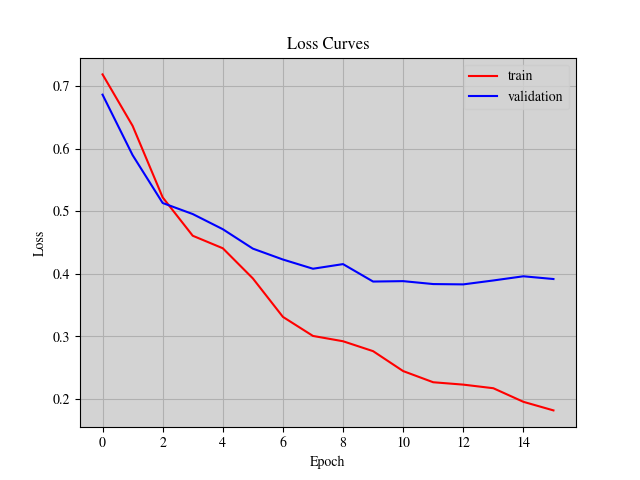

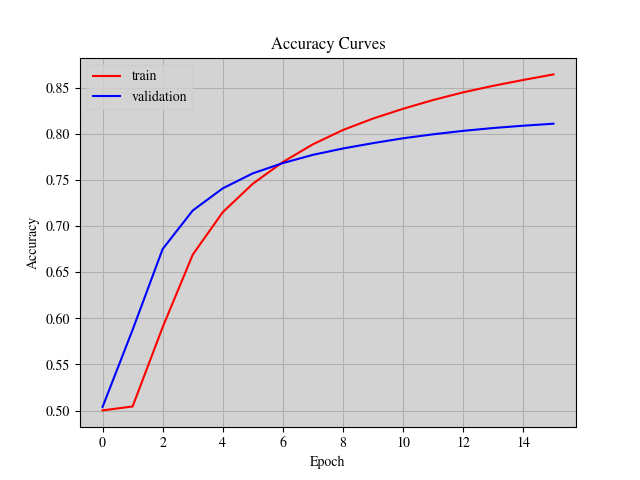

<Figure size 640x480 with 0 Axes>

In [ ]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)

    model = MODEL()
    datamodule = DATASET()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
    )
    callbacks.append(checkpoint)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAX_EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, datamodule=datamodule, ckpt_path=ckpt_path)

_train_loop()

## **Testing**

In [ ]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL()
    datamodule = DATASET()
    trainer.test(model=model, datamodule=datamodule, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/model/QuantumTransferLearning_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/QuantumTransferLearning_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/model/QuantumTransferLearning_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at experiment/model/QuantumTransferLearning_best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8029377460479736     │
│         test_loss         │    0.46380922198295593    │
└───────────────────────────┴───────────────────────────┘

## **Inference**

<Figure size 640x480 with 0 Axes>

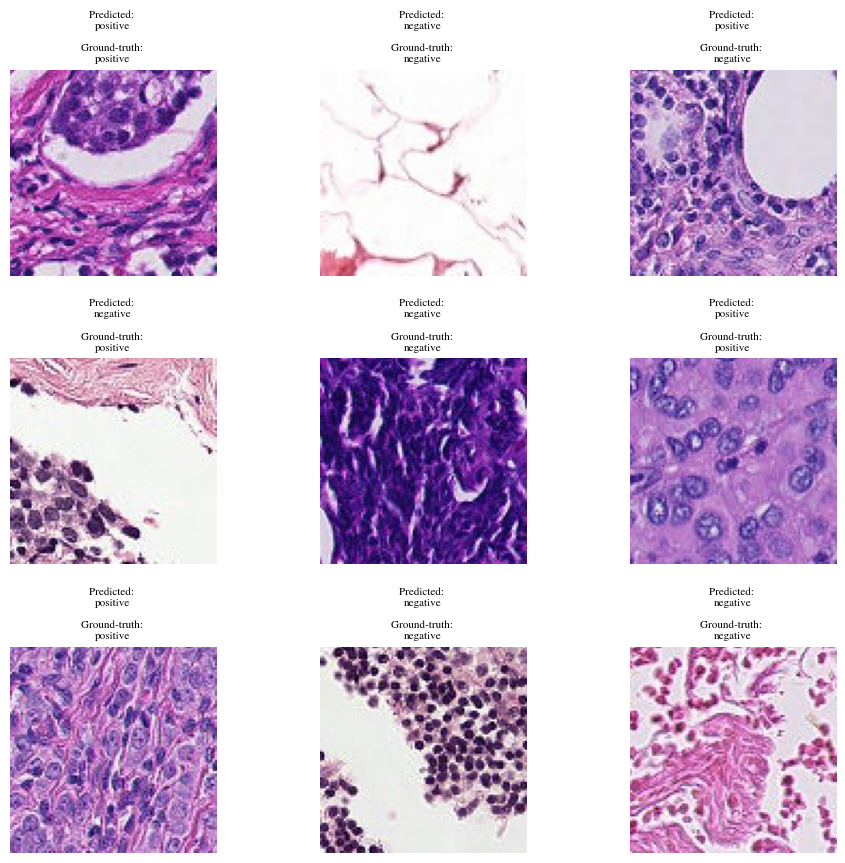

In [ ]:
model = MODEL.load_from_checkpoint(BEST_MODEL_PATH)
model.eval()

test_dataset = DATASET()
test_dataset.prepare_data()
test_dataset.setup("test")
test_dataset = test_dataset.test_set

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)


classes = {
    0: "negative",
    1: "positive"
}


for index in range(9):
    sample_index = random.randint(0, len(test_dataset) - 1)

    targets_file = test_dataset._FILES[test_dataset._split]["targets"][0]
    with test_dataset.h5py.File(
        test_dataset._base_folder / targets_file
    ) as targets_data:
        target = classes[int(targets_data["y"][sample_index, 0, 0, 0])]

    images_file = test_dataset._FILES[test_dataset._split]["images"][0]
    with test_dataset.h5py.File(
        test_dataset._base_folder / images_file
    ) as images_data:
        img_raw = Image.fromarray(images_data["x"][sample_index]).convert("RGB")

    img = test_dataset.transform(img_raw).unsqueeze(0).to(
        "cuda" if torch.cuda.is_available() else "cpu"
    )

    prediction = model(img).sigmoid()
    prediction[prediction >= 0.5] = 1.
    prediction = classes[
        int(math.floor(prediction.data.cpu().numpy()))
    ]

    title = f"Predicted: \n{prediction}\n\n"
    title += f"Ground-truth: \n{target}"

    ax = fig.add_subplot(3, 3, index + 1)

    ax.imshow(np.array(img_raw).astype(np.uint8), cmap='inferno')
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()